# Customer Churn Prediction 

## Introduction <a id="introduction"></a>

**Customer churn**, which occurs when customers discontinue using a service, poses a significant challenge for businesses, particularly in the telecom, banking, and subscription-based sectors. Losing customers translates to a loss of revenue, so being able to predict which customers are likely to leave and understanding the reasons behind their departure can help businesses take proactive measures to retain them.

This project aims to develop a machine-learning model to predict customer churn by analyzing factors such as account details, service usage, and payment methods. By identifying patterns and training predictive models, we can assist businesses in recognizing at-risk customers and taking steps to prevent their departure.

**The project involves the following steps:**

**Understanding the Data:** Analyzing customer behaviour and identifying key indicators of churn.
**Data Preparation:** Cleaning, encoding, and balancing the dataset to enhance model accuracy.

**Model Training & Optimisation:** Testing various machine learning models (e.g., Random Forest, XGBoost) and fine-tuning them for optimal performance.

**Evaluating Performance:** Assessing accuracy, precision, recall, and identifying false predictions.

**Building a Predictive System:** Enabling real-time customer churn predictions based on input data.

With this model, businesses can detect potential churn early and take actions such as improving customer support, offering personalized deals, or enhancing services, ultimately reducing customer loss and boosting retention

## Imports

In [1]:
# Import essential libraries
import pandas as pd
import numpy as np

# Import visualisation libraries
import matplotlib.pyplot as plt
import seaborn as sns

# Suppress warnings for cleaner output
import warnings
warnings.filterwarnings("ignore")

# Import preprocessing tools
from sklearn.preprocessing import LabelEncoder
from imblearn.over_sampling import SMOTE

# Import machine learning tools
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV

# Import evaluation metrics
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_auc_score

# Import serialisation tool
import pickle

## Data Loading

In [3]:
# Load the dataset
df = pd.read_csv('WA_Fn-UseC_-Telco-Customer-Churn.csv')
print("Dataset Loaded:", df.shape)

Dataset Loaded: (7043, 21)


In [4]:
# Display dataset structure and types
df.info()

# Ensure all columns are displayed when viewing DataFrame
pd.set_option("display.max_columns", None)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   tenure            7043 non-null   int64  
 6   PhoneService      7043 non-null   object 
 7   MultipleLines     7043 non-null   object 
 8   InternetService   7043 non-null   object 
 9   OnlineSecurity    7043 non-null   object 
 10  OnlineBackup      7043 non-null   object 
 11  DeviceProtection  7043 non-null   object 
 12  TechSupport       7043 non-null   object 
 13  StreamingTV       7043 non-null   object 
 14  StreamingMovies   7043 non-null   object 
 15  Contract          7043 non-null   object 
 16  PaperlessBilling  7043 non-null   object 


In [5]:
# Drop 'customerID' as it is a unique identifier and not useful for modelling
df = df.drop(columns=["customerID"])

In [6]:
# Identify categorical columns and print their unique values
numerical_features = ["tenure", "MonthlyCharges", "TotalCharges"]

for col in df.columns:
    if col not in numerical_features:
        print(f"{col}: {df[col].unique()}")
        print("-" * 50)

gender: ['Female' 'Male']
--------------------------------------------------
SeniorCitizen: [0 1]
--------------------------------------------------
Partner: ['Yes' 'No']
--------------------------------------------------
Dependents: ['No' 'Yes']
--------------------------------------------------
PhoneService: ['No' 'Yes']
--------------------------------------------------
MultipleLines: ['No phone service' 'No' 'Yes']
--------------------------------------------------
InternetService: ['DSL' 'Fiber optic' 'No']
--------------------------------------------------
OnlineSecurity: ['No' 'Yes' 'No internet service']
--------------------------------------------------
OnlineBackup: ['Yes' 'No' 'No internet service']
--------------------------------------------------
DeviceProtection: ['No' 'Yes' 'No internet service']
--------------------------------------------------
TechSupport: ['No' 'Yes' 'No internet service']
--------------------------------------------------
StreamingTV: ['No' 'Yes' '

In [7]:
# Check for missing values in the dataset
print("Missing values per column:\n", df.isnull().sum())

Missing values per column:
 gender              0
SeniorCitizen       0
Partner             0
Dependents          0
tenure              0
PhoneService        0
MultipleLines       0
InternetService     0
OnlineSecurity      0
OnlineBackup        0
DeviceProtection    0
TechSupport         0
StreamingTV         0
StreamingMovies     0
Contract            0
PaperlessBilling    0
PaymentMethod       0
MonthlyCharges      0
TotalCharges        0
Churn               0
dtype: int64


In [8]:
# Identify rows where 'TotalCharges' contains an empty string instead of a numeric value
empty_total_charges = df[df["TotalCharges"] == " "]
print(f"Rows with empty 'TotalCharges': {len(empty_total_charges)}")

Rows with empty 'TotalCharges': 11


In [9]:
# Replace empty values in 'TotalCharges' with 0.0 and convert column to float
df["TotalCharges"] = df["TotalCharges"].replace(" ", "0.0").astype(float)

In [10]:
# Verify that 'TotalCharges' is now a numerical column
df["TotalCharges"].info()

<class 'pandas.core.series.Series'>
RangeIndex: 7043 entries, 0 to 7042
Series name: TotalCharges
Non-Null Count  Dtype  
--------------  -----  
7043 non-null   float64
dtypes: float64(1)
memory usage: 55.2 KB


In [11]:
# Check class distribution of the target variable
print(df["Churn"].value_counts())

Churn
No     5174
Yes    1869
Name: count, dtype: int64


The dataset is imbalanced, with 5,174 customers who stayed and 1,869 who churned. Since the model could end up biased towards predicting that customers will stay, we need to balance the data to give it a fair chance to learn from both groups. This will help improve the accuracy of churn predictions.

## Exploratory Data Analysis

In [12]:
df.describe()

,SeniorCitizen,tenure,MonthlyCharges,TotalCharges
count,7043.000000,7043.000000,7043.000000,7043.000000
mean,0.162147,32.371149,64.761692,2279.734304
std,0.368612,24.559481,30.090047,2266.794470
min,0.000000,0.000000,18.250000,0.000000
25%,0.000000,9.000000,35.500000,398.550000
50%,0.000000,29.000000,70.350000,1394.550000
75%,0.000000,55.000000,89.850000,3786.600000
max,1.000000,72.000000,118.750000,8684.800000


Only 16.2% of customers are senior citizens. Tenure ranges from 0 to 72 months, averaging 32.37 months, while MonthlyCharges span \$18.25 to \$118.75, with a median of \$70.35. TotalCharges varies widely from \$0 to \$8684.80, with a median of $1394.55. This shows that customers have very different spending habits, some pay only a little, while others spend a lot over time. The wide range in total charges highlights the variety in how long customers stay and how much they invest in the service.

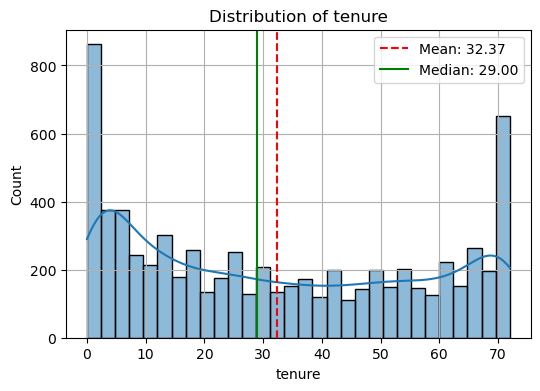

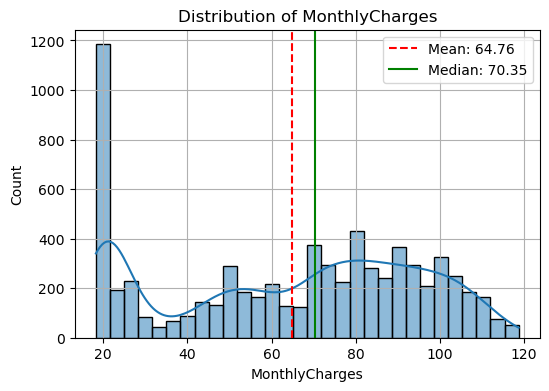

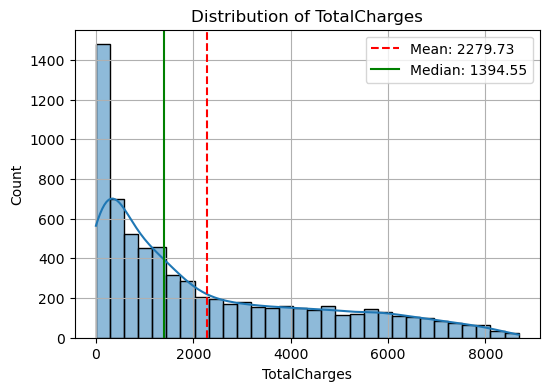

In [13]:
# Function to plot a histogram with mean & median lines
def plot_hist(df, column_name):
    plt.figure(figsize=(6, 4))
    sns.histplot(df[column_name], kde=True, bins=30)
    plt.title(f"Distribution of {column_name}")

    col_mean = df[column_name].mean()
    col_median = df[column_name].median()

    plt.axvline(col_mean, color="red", linestyle="--", label=f"Mean: {col_mean:.2f}")
    plt.axvline(col_median, color="green", linestyle="-", label=f"Median: {col_median:.2f}")

    plt.legend()
    plt.grid(True)
    plt.show()

# Plot histograms for key numerical features
plot_hist(df, "tenure")
plot_hist(df, "MonthlyCharges")
plot_hist(df, "TotalCharges")

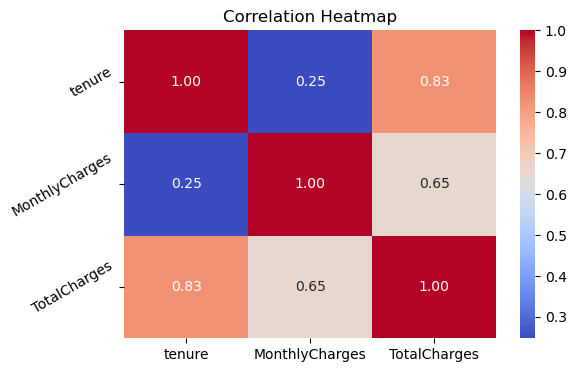

In [14]:
# Correlation heatmap between numerical features
plt.figure(figsize=(6, 4))
sns.heatmap(df[["tenure", "MonthlyCharges", "TotalCharges"]].corr(), annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation Heatmap")
plt.yticks(rotation=30)
plt.show()

In [15]:
# Creating a function to create a box plot for the desired feature
def lot_box(df, columns):
    for column in columns:
        plt.figure(figsize=(10, 6))
        sns.boxplot(x=column, data=df)
        plt.title(f'Box plot of {column}')
        plt.show()

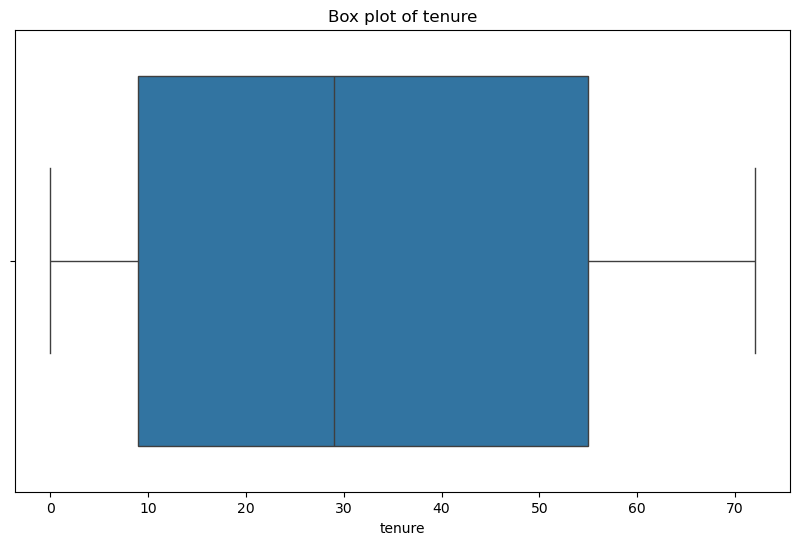

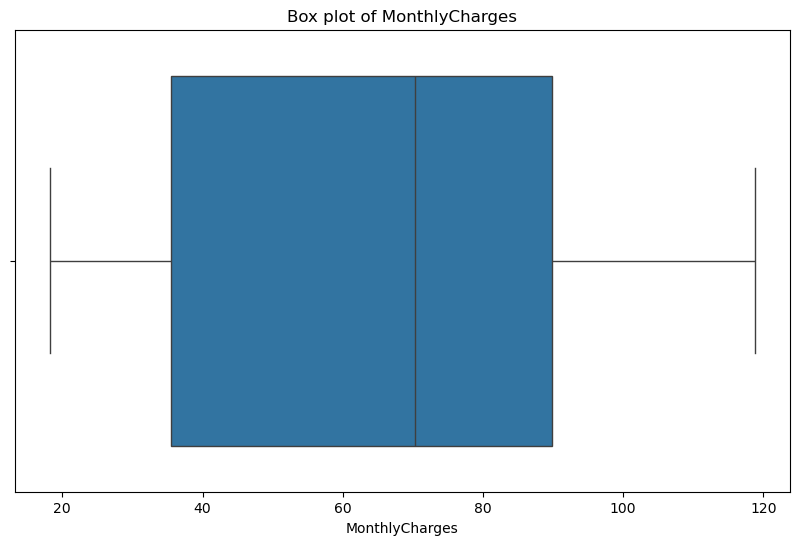

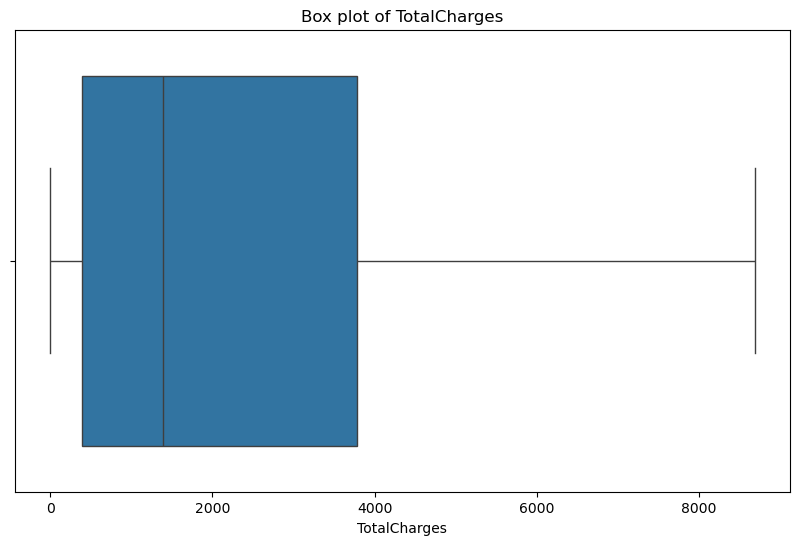

In [16]:
# Usage
columns_to_plot = ["tenure", "MonthlyCharges", "TotalCharges"]
lot_box(df, columns_to_plot)

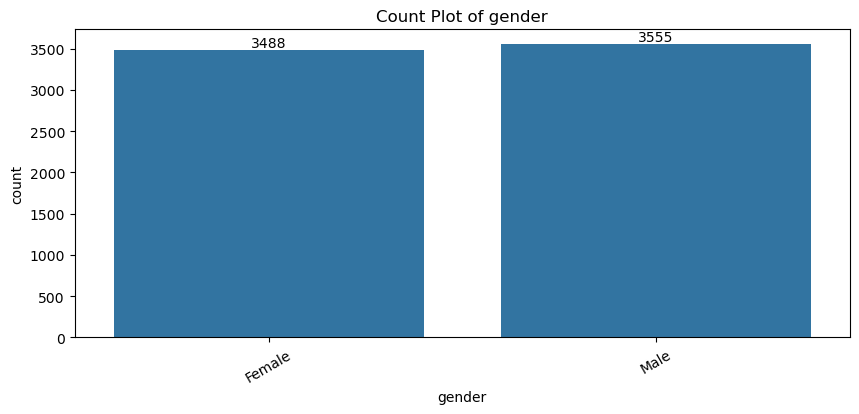

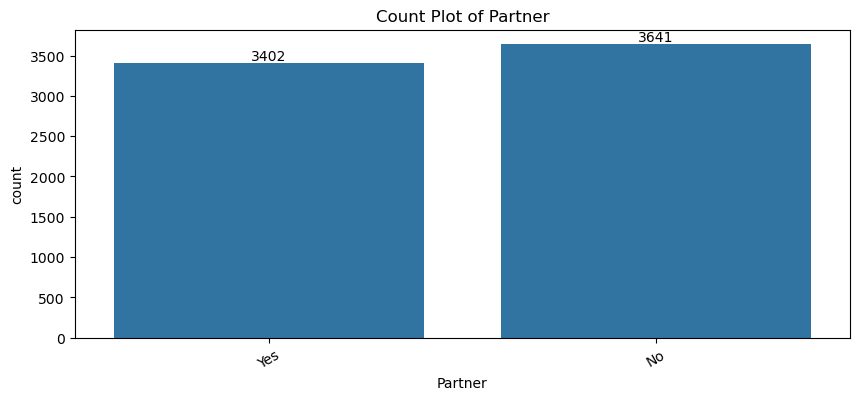

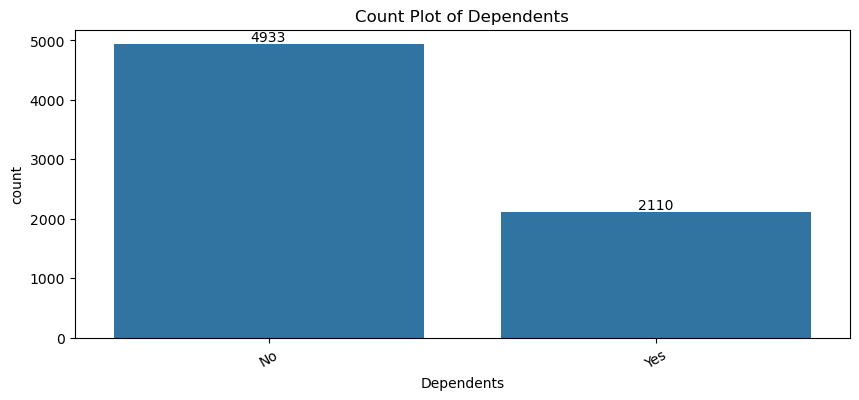

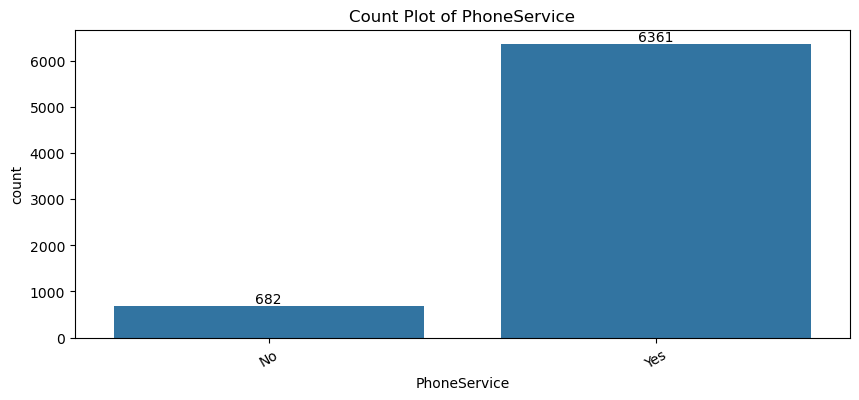

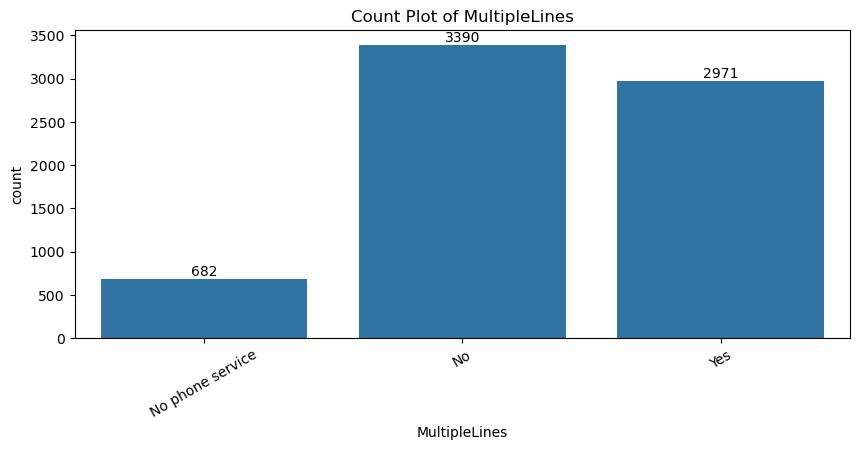

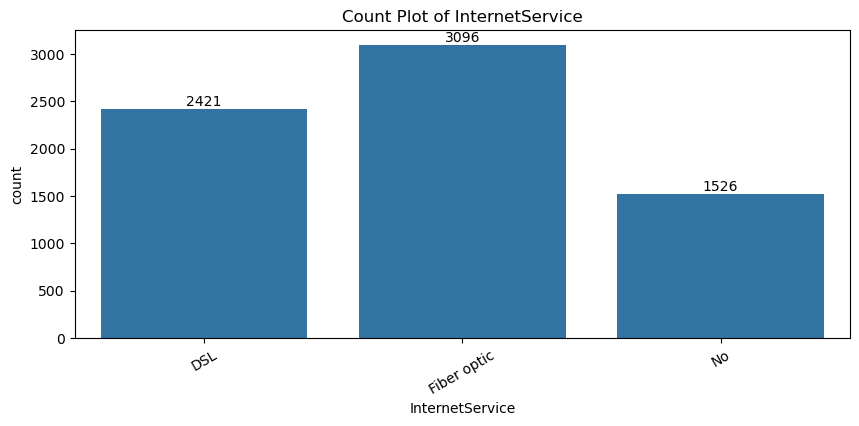

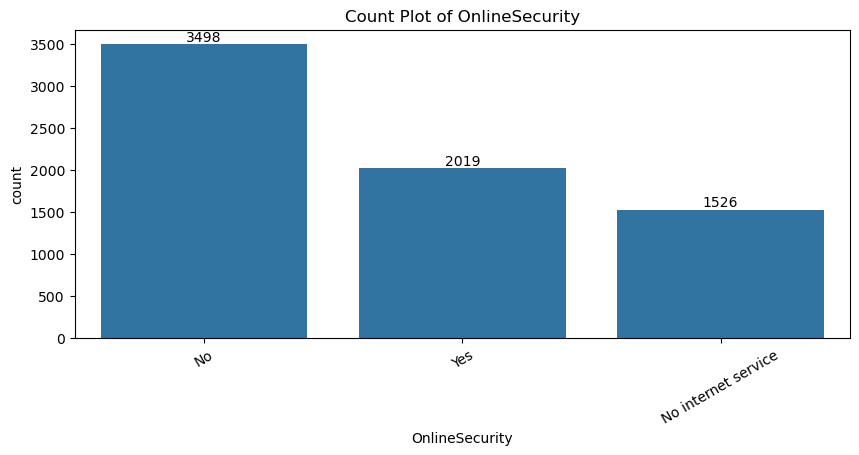

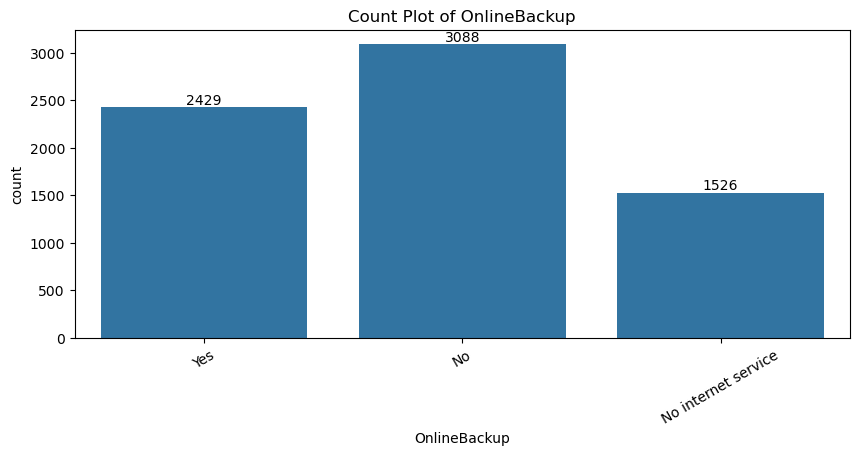

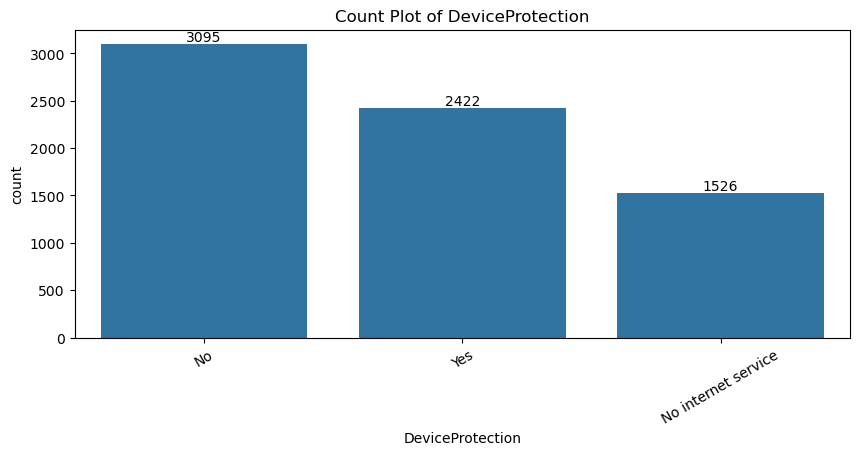

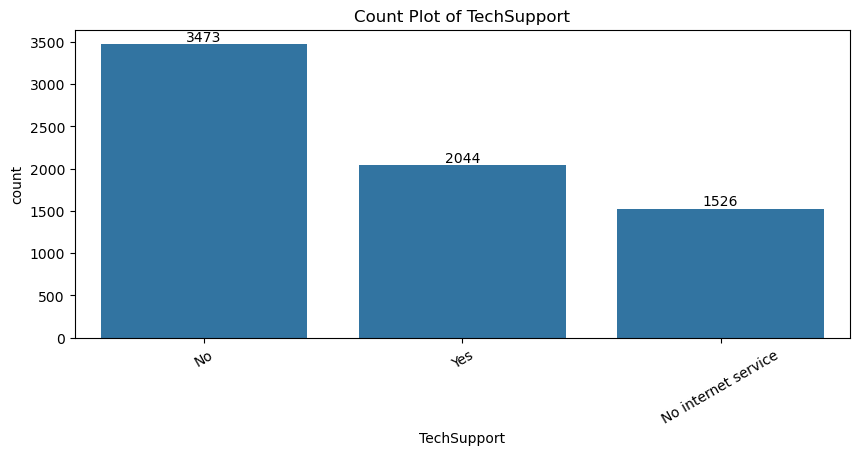

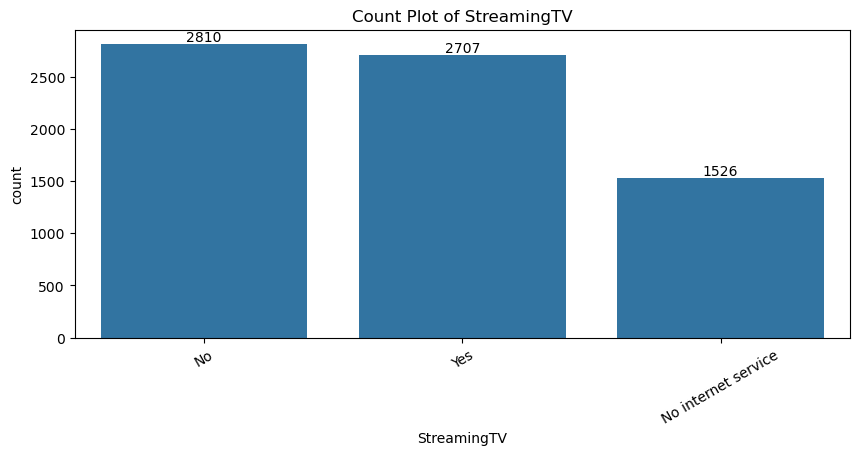

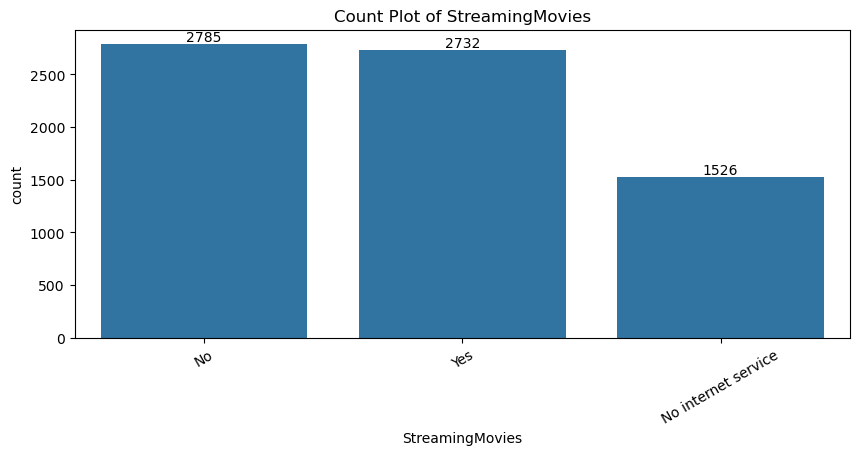

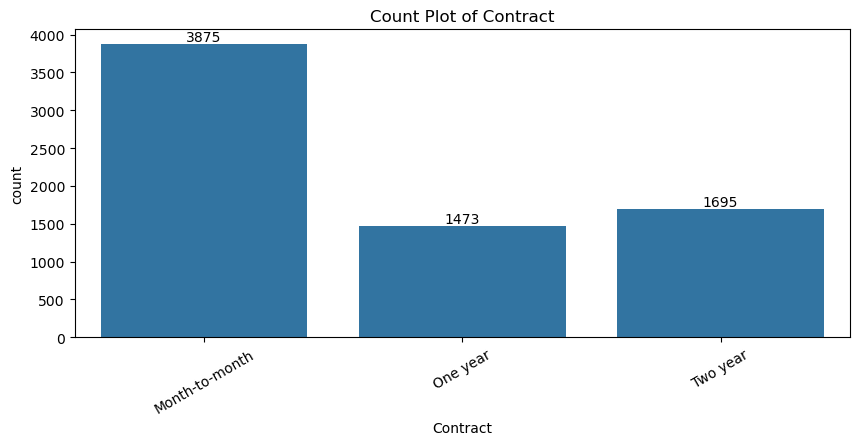

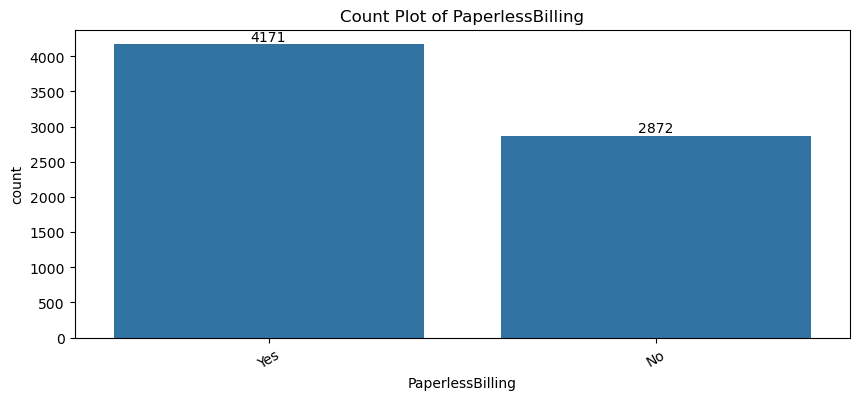

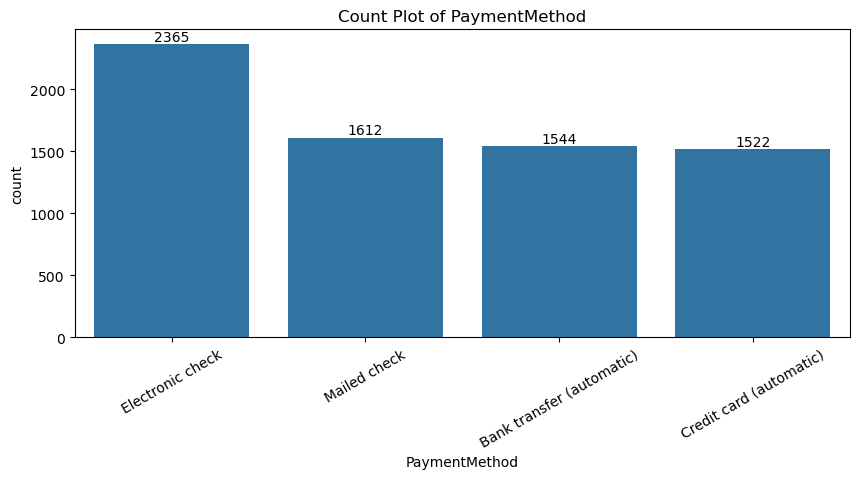

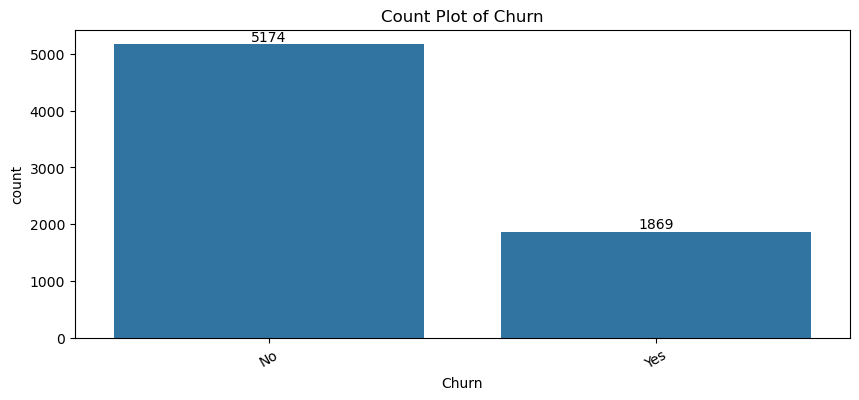

In [17]:
# Identify categorical columns
object_cols = df.select_dtypes(include="object").columns.to_list()

# Count plots for categorical features with value annotations
for col in object_cols:
    plt.figure(figsize=(10, 4))
    ax = sns.countplot(x=df[col])

    # Add count annotations above each bar
    for p in ax.patches:
        ax.annotate(f'{int(p.get_height())}',
                    (p.get_x() + p.get_width() / 2, p.get_height()),
                    ha='center', va='bottom', fontsize=10)

    plt.title(f"Count Plot of {col}")
    plt.xticks(rotation=30)
    plt.show()


## Data Preprocessing

In [18]:
# Encode the target variable: 'No' = 0, 'Yes' = 1
df["Churn"] = df["Churn"].replace({"No": 0, "Yes": 1})

In [19]:
# One-hot encode 'PaymentMethod', keeping all categories
df = pd.get_dummies(df, columns=['PaymentMethod'])

# Remove prefix from new one-hot encoded columns
df.rename(columns=lambda x: x.replace("PaymentMethod_", ""), inplace=True)

# Convert only one-hot encoded columns to numerical format
one_hot_columns = df.select_dtypes(include=["bool"]).columns
df[one_hot_columns] = df[one_hot_columns].astype(int)

# Verify data types
print(df.dtypes)

gender                        object
SeniorCitizen                  int64
Partner                       object
Dependents                    object
tenure                         int64
PhoneService                  object
MultipleLines                 object
InternetService               object
OnlineSecurity                object
OnlineBackup                  object
DeviceProtection              object
TechSupport                   object
StreamingTV                   object
StreamingMovies               object
Contract                      object
PaperlessBilling              object
MonthlyCharges               float64
TotalCharges                 float64
Churn                          int64
Bank transfer (automatic)      int32
Credit card (automatic)        int32
Electronic check               int32
Mailed check                   int32
dtype: object


In [20]:
# Identify categorical columns (excluding the target variable)
object_cols = df.select_dtypes(include="object").columns.to_list()

# Dictionary to store label encoders
encoders = {}

# Apply label encoding to categorical features
for col in object_cols:
    label_encoder = LabelEncoder()
    df[col] = label_encoder.fit_transform(df[col])
    encoders[col] = label_encoder

# Save encoders to a pickle file
with open("encoders.pkl", "wb") as f:
    pickle.dump(encoders, f)

In [21]:
# Separate features (X) and target variable (y)
X = df.drop(columns=["Churn"])
y = df["Churn"]

In [22]:
# Split data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Check class distribution before resampling
print("Before SMOTE:\n", y_train.value_counts())

Before SMOTE:
 Churn
0    4138
1    1496
Name: count, dtype: int64


In [23]:
# Apply SMOTE to balance the dataset
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

# Check class distribution after resampling
print("After SMOTE:\n", y_train_resampled.value_counts())

After SMOTE:
 Churn
0    4138
1    4138
Name: count, dtype: int64


The dataset has been oversampled and balanced using SMOTE, resulting in both classes (0 and 1) having 4,138 instances each. 

SMOTE is designed to generate synthetic samples for the minority class to balance the dataset. This helps improve the performance of machine learning models on imbalanced datasets

## Model Training 

In [29]:
# Define models with default hyperparameters
models = {
    "Decision Tree": DecisionTreeClassifier(random_state=42),
    "Random Forest": RandomForestClassifier(random_state=42),
    "XGBoost": XGBClassifier(random_state=42)
}

In [34]:
# Dictionary to store cross-validation results and trained models
cv_scores = {}
trained_models = {}

In [31]:
# Perform 5-fold cross-validation and train each model
for model_name, model in models.items():
    print(f"Training {model_name} with default hyperparameters...")

    # Cross-validation
    cv_score = cross_val_score(model, X_train_resampled, y_train_resampled, cv=5, scoring="accuracy")
    cv_scores[model_name] = cv_score.mean() 

    # Train the model on full training data
    model.fit(X_train_resampled, y_train_resampled)
    trained_models[model_name] = model

    print(f"{model_name} - Mean Cross-Validation Accuracy: {cv_score.mean():.4f}")
    print("-" * 50)

Training Decision Tree with default hyperparameters...
Decision Tree - Mean Cross-Validation Accuracy: 0.7906
--------------------------------------------------
Training Random Forest with default hyperparameters...
Random Forest - Mean Cross-Validation Accuracy: 0.8405
--------------------------------------------------


In [32]:
#  parameter grid for Random Forest
rf_param_grid = {
    "n_estimators": [75, 100, 125],
    "max_depth": [21, 22, 23, 24, 25],
    "min_samples_split": [2, 3, 4]
}

In [33]:
#  GridSearchCV for Random Forest
rf_grid_search = GridSearchCV(RandomForestClassifier(random_state=42),
                              rf_param_grid,
                              cv=5,
                              scoring="accuracy",
                              n_jobs=-1)

rf_grid_search.fit(X_train_resampled, y_train_resampled)

GridSearchCV(cv=5, estimator=RandomForestClassifier(random_state=42), n_jobs=-1,
             param_grid={'max_depth': [21, 22, 23, 24, 25],
                         'min_samples_split': [2, 3, 4],
                         'n_estimators': [75, 100, 125]},
             scoring='accuracy')

In [35]:
# Print the best parameters and best score for Random Forest
print("Best Parameters for Random Forest:", rf_grid_search.best_params_)
print("Best Accuracy Score:", rf_grid_search.best_score_)

Best Parameters for Random Forest: {'max_depth': 23, 'min_samples_split': 4, 'n_estimators': 100}
Best Accuracy Score: 0.8422087948976167


In [31]:
# Define parameter grid for XGBoost
xgb_param_grid = {
    "n_estimators": [190, 200, 210],
    "max_depth": [5, 6, 7],
    "learning_rate": [0.9, 0.1, 1.1]
}

In [32]:
# Perform GridSearchCV for XGBoost
xgb_grid_search = GridSearchCV(XGBClassifier(random_state=42),
                               xgb_param_grid,
                               cv=5,
                               scoring="accuracy",
                               n_jobs=-1)

xgb_grid_search.fit(X_train_resampled, y_train_resampled)

GridSearchCV(cv=5,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, device=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     feature_types=None, gamma=None,
                                     grow_policy=None, importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=None,...
                                     max_cat_threshold=None,
                                     max_cat_to_onehot=None,
                                     max_delta_step=None, max_depth=None,
                                     max_leaves=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     multi_strategy=None, n_estimators=None,
                                     n_jobs=None, num_parallel_tree=None,
                                     random_state=42, ...),
             n_jobs=-1,
             param_grid={'learning_rate': [0.9, 0.1, 1.1],
                         'max_depth': [5, 6, 7],
                         'n_estimators': [190, 200, 210]},
             scoring='accuracy')

In [33]:
# Print the best parameters and best score for XGBoost
print("Best Parameters for XGBoost:", xgb_grid_search.best_params_)
print("Best Accuracy Score:", xgb_grid_search.best_score_)

Best Parameters for XGBoost: {'learning_rate': 0.1, 'max_depth': 7, 'n_estimators': 200}
Best Accuracy Score: 0.8367729906446575


The Random Forest model at first achieved a cross-validation accuracy of 83.88%, while XGBoost scored 83.51%. However, after hyperparameter tuning, Random Forest's accuracy improved to 84.22%, surpassing XGBoost's 83.96%.

## Model Evaluation 

In [34]:
# Check class distribution in test data
print("Test Set Class Distribution:\n", y_test.value_counts())

Test Set Class Distribution:
 Churn
0    1036
1     373
Name: count, dtype: int64


In [35]:
# Evaluate Random Forest on test data
y_pred_rf = rf_grid_search.best_estimator_.predict(X_test)

accuracy_rf = accuracy_score(y_test, y_pred_rf)
confusion_rf = confusion_matrix(y_test, y_pred_rf)
classification_report_rf = classification_report(y_test, y_pred_rf)
roc_auc_rf = roc_auc_score(y_test, y_pred_rf)

print(f"Random Forest Accuracy: {accuracy_rf:.4f}")
print(f"Random Forest ROC-AUC Score: {roc_auc_rf:.4f}")
print(f"Confusion Matrix:\n{confusion_rf}")
print(f"Classification Report:\n{classification_report_rf}")

Random Forest Accuracy: 0.7821
Random Forest ROC-AUC Score: 0.7154
Confusion Matrix:
[[888 148]
 [159 214]]
Classification Report:
              precision    recall  f1-score   support

           0       0.85      0.86      0.85      1036
           1       0.59      0.57      0.58       373

    accuracy                           0.78      1409
   macro avg       0.72      0.72      0.72      1409
weighted avg       0.78      0.78      0.78      1409



The Random Forest model achieved an accuracy of 77.93%, accurately predicting most customer outcomes. However, its recall for churners (58%) indicates it misses a significant number of actual churn cases, meaning some at-risk customers are not being identified. The confusion matrix reveals that while the model correctly classified 883 non-churners and 215 churners, it also misclassified 158 churners as staying and 153 non-churners as leaving, potentially leading to unnecessary retention efforts.

The ROC-AUC score of 0.7144 suggests a moderate ability to distinguish between churners and non-churners, but there is room for improvement

In [36]:
# Evaluate XGBoost on test data
y_pred_xgb = xgb_grid_search.best_estimator_.predict(X_test)

accuracy_xgb = accuracy_score(y_test, y_pred_xgb)
confusion_xgb = confusion_matrix(y_test, y_pred_xgb)
classification_report_xgb = classification_report(y_test, y_pred_xgb)
roc_auc_xgb = roc_auc_score(y_test, y_pred_xgb)

print(f"XGBoost Accuracy: {accuracy_xgb:.4f}")
print(f"XGBoost ROC-AUC Score: {roc_auc_xgb:.4f}")
print(f"Confusion Matrix:\n{confusion_xgb}")
print(f"Classification Report:\n{classification_report_xgb}")

XGBoost Accuracy: 0.7949
XGBoost ROC-AUC Score: 0.7301
Confusion Matrix:
[[899 137]
 [152 221]]
Classification Report:
              precision    recall  f1-score   support

           0       0.86      0.87      0.86      1036
           1       0.62      0.59      0.60       373

    accuracy                           0.79      1409
   macro avg       0.74      0.73      0.73      1409
weighted avg       0.79      0.79      0.79      1409



The XGBoost model outperformed Random Forest slightly, achieving an accuracy of 79.99% and a ROC-AUC score of 0.7387, indicating a stronger ability to distinguish churners from non-churners. It correctly classified 900 non-churners and 227 churners, but still misclassified 146 churners as staying and 136 non-churners as leaving.

With a recall of 61% for churners, XGBoost does a slightly better job at identifying customers likely to leave compared to Random Forest (58%), though it still misses a significant portion. The precision for churners (63%) means that 37% of predicted churn cases were actually non-churners.

Overall, XGBoost demonstrates moderate improvement over Random Forest, offering a better balance between correctly identifying churners and minimizing false alarms.

In [37]:
# Save the best performing model
best_model = rf_grid_search.best_estimator_ if accuracy_rf > accuracy_xgb else xgb_grid_search.best_estimator_

model_data = {
    "model": best_model,
    "feature_names": X.columns.tolist()
}

with open("customer_churn_model.pkl", "wb") as f:
    pickle.dump(model_data, f)

print("Best model saved as 'customer_churn_model.pkl'")

Best model saved as 'customer_churn_model.pkl'


## Building a Predictive System 

In [38]:
# Load the trained model and feature names
with open("customer_churn_model.pkl", "rb") as f:
    model_data = pickle.load(f)

loaded_model = model_data["model"]
feature_names = model_data["feature_names"]

print("Model Loaded Successfully")

Model Loaded Successfully


In [39]:
# Sample input data
input_data = {
    'gender': 'Female',
    'SeniorCitizen': 0,
    'Partner': 'Yes',
    'Dependents': 'No',
    'tenure': 1,
    'PhoneService': 'No',
    'MultipleLines': 'No phone service',
    'InternetService': 'DSL',
    'OnlineSecurity': 'No',
    'OnlineBackup': 'Yes',
    'DeviceProtection': 'No',
    'TechSupport': 'No',
    'StreamingTV': 'No',
    'StreamingMovies': 'No',
    'Contract': 'Month-to-month',
    'PaperlessBilling': 'Yes',
    'PaymentMethod': 'Electronic check',
    'MonthlyCharges': 29.85,
    'TotalCharges': 29.85
}

In [40]:
# Convert input dictionary to a DataFrame
input_data_df = pd.DataFrame([input_data])

In [41]:
# Load encoders
with open("encoders.pkl", "rb") as f:
    encoders = pickle.load(f)

# Remove 'Churn' encoder if present
encoders.pop("Churn", None)

In [42]:
# Encode categorical features using the saved label encoders
for column, encoder in encoders.items():
    if column in input_data_df.columns:  # Ensure column exists in input
        input_data_df[column] = encoder.transform(input_data_df[column])

In [43]:
# One-hot encode 'PaymentMethod' (since it was one-hot encoded earlier)
payment_methods = ["Bank transfer (automatic)", "Credit card (automatic)", "Electronic check", "Mailed check"]

for method in payment_methods:
    col_name = method  # Ensure we use the simplified column names
    input_data_df[col_name] = 1 if input_data["PaymentMethod"] == method else 0

# Drop 'PaymentMethod' original column if it still exists
input_data_df.drop(columns=["PaymentMethod"], errors="ignore", inplace=True)

In [44]:
# Ensure input data has the same columns as training data (fills missing columns with 0)
for col in feature_names:
    if col not in input_data_df.columns:
        input_data_df[col] = 0  # Assign default value for missing columns

In [45]:
# Reorder columns to match the training dataset
input_data_df = input_data_df[feature_names]

In [46]:
# Make a prediction
prediction = loaded_model.predict(input_data_df)
prediction_proba = loaded_model.predict_proba(input_data_df)

In [47]:
# Display results
print(f"Prediction: {'Will Churn' if prediction[0] == 1 else 'Will Not Churn'}")
print(f"Prediction Probability: {prediction_proba}")

Prediction: Will Not Churn
Prediction Probability: [[0.5443635  0.45563647]]


## Evaluation

This project developed a machine learning model to predict customer churn, enabling businesses to identify at-risk customers before they leave. XGBoost outperformed Random Forest, achieving an accuracy of 79.99% and demonstrating a superior ability to distinguish churners. However, both models struggled with recall (61% for XGBoost, 58% for Random Forest), indicating that many actual churners were still missed.

Key factors influencing churn included tenure, contract type, and payment method, with month-to-month contracts and electronic check payments associated with higher churn rates. Balancing the dataset using SMOTE improved performance, and hyperparameter tuning refined the models, but recall issues persisted.

While the models provide valuable insights, they still miss some churners. Further improvements could involve adjusting the decision threshold, enhancing feature engineering, or exploring advanced models. Despite these challenges, the system offers businesses a practical tool for reducing churn through proactive engagement.

### End-to-End Problem Solution

Data Collection and Preprocessing: The notebook starts with loading the Telco Customer Churn dataset and performing necessary preprocessing steps, such as handling missing values, encoding categorical variables, and scaling numerical features.

**Balancing the Dataset:** The dataset is balanced using SMOTE to ensure that the minority class (churners) is adequately represented, which was crucial for training effective models.

**Model Selection and Training:** Multiple machine learning models, including Random Forest and XGBoost, are trained and evaluated. The notebook compares their performance using metrics like accuracy and ROC-AUC.

**Deployment and Monitoring:** Although not covered in the notebook, the final step would involve deploying the best-performing model and monitoring its performance over time.

### Interesting or Challenging Aspects
**Feature Engineering:** One interesting aspect is the process of feature engineering, where new features are created or existing ones are transformed to improve model performance. This step required creativity and domain knowledge to identify meaningful features.

**Balancing the Dataset:** A challenging aspect was balancing the dataset using SMOTE. While it helped in improving model performance, it also had the potential to introduce noise and overfitting if not done carefully. 